#Simple QNN for MNIST classification

In [3]:
import torch
import pennylane as qml
from time import time
from tqdm import tqdm
import numpy as np

Definition of PennyLane circuit

In [44]:
NUM_QUBITS = 8
NUM_LAYERS = 3

# get the device
dev = qml.device("default.qubit", wires=NUM_QUBITS)

# circuit using the strongly entangling layer ansatz
@qml.qnode(dev, interface="torch")
def circuit_block(params, state=None):

    # Load the initial state if provided
    if state is not None: qml.QubitStateVector(state, wires=range(NUM_QUBITS))

    # Real quantum encoding (using amplitude encoding)
    #if state is not None: qml.AmplitudeEmbedding(features=state, wires=range(NUM_QUBITS))

    #qml.StronglyEntanglingLayers(params, wires=range(NUM_QUBITS), ranges = [1]*params.shape[0])

    # Quantum circuit
    for i in range(NUM_LAYERS):

      # Rotation layer
      for j in range(NUM_QUBITS):
          qml.RX(params[i, j, 0], wires=j)
          qml.RY(params[i, j, 1], wires=j)
          qml.RZ(params[i, j, 2], wires=j)

      # Entangling layer
      for j in range(NUM_QUBITS):
          qml.CNOT(wires=[j, (j + 1) % NUM_QUBITS])


    # Return the state vector
    return qml.state()

  # define general circuit
def circuit(params, state):

    # apply first small block
    state = circuit_block(params, state)

    # return probability of measuring |0> in the first qubit
    return measure(state)

# define function that outputs the probability of mesuring |0> in the first qubit
def measure(state):

    # compute the probability of measuring |0> in the first qubit
    prob = torch.sum(torch.abs(state[:,:2**(NUM_QUBITS-1)])**2, dim = 1)

    # cast to float32
    prob = prob.type(torch.float32)

    return prob

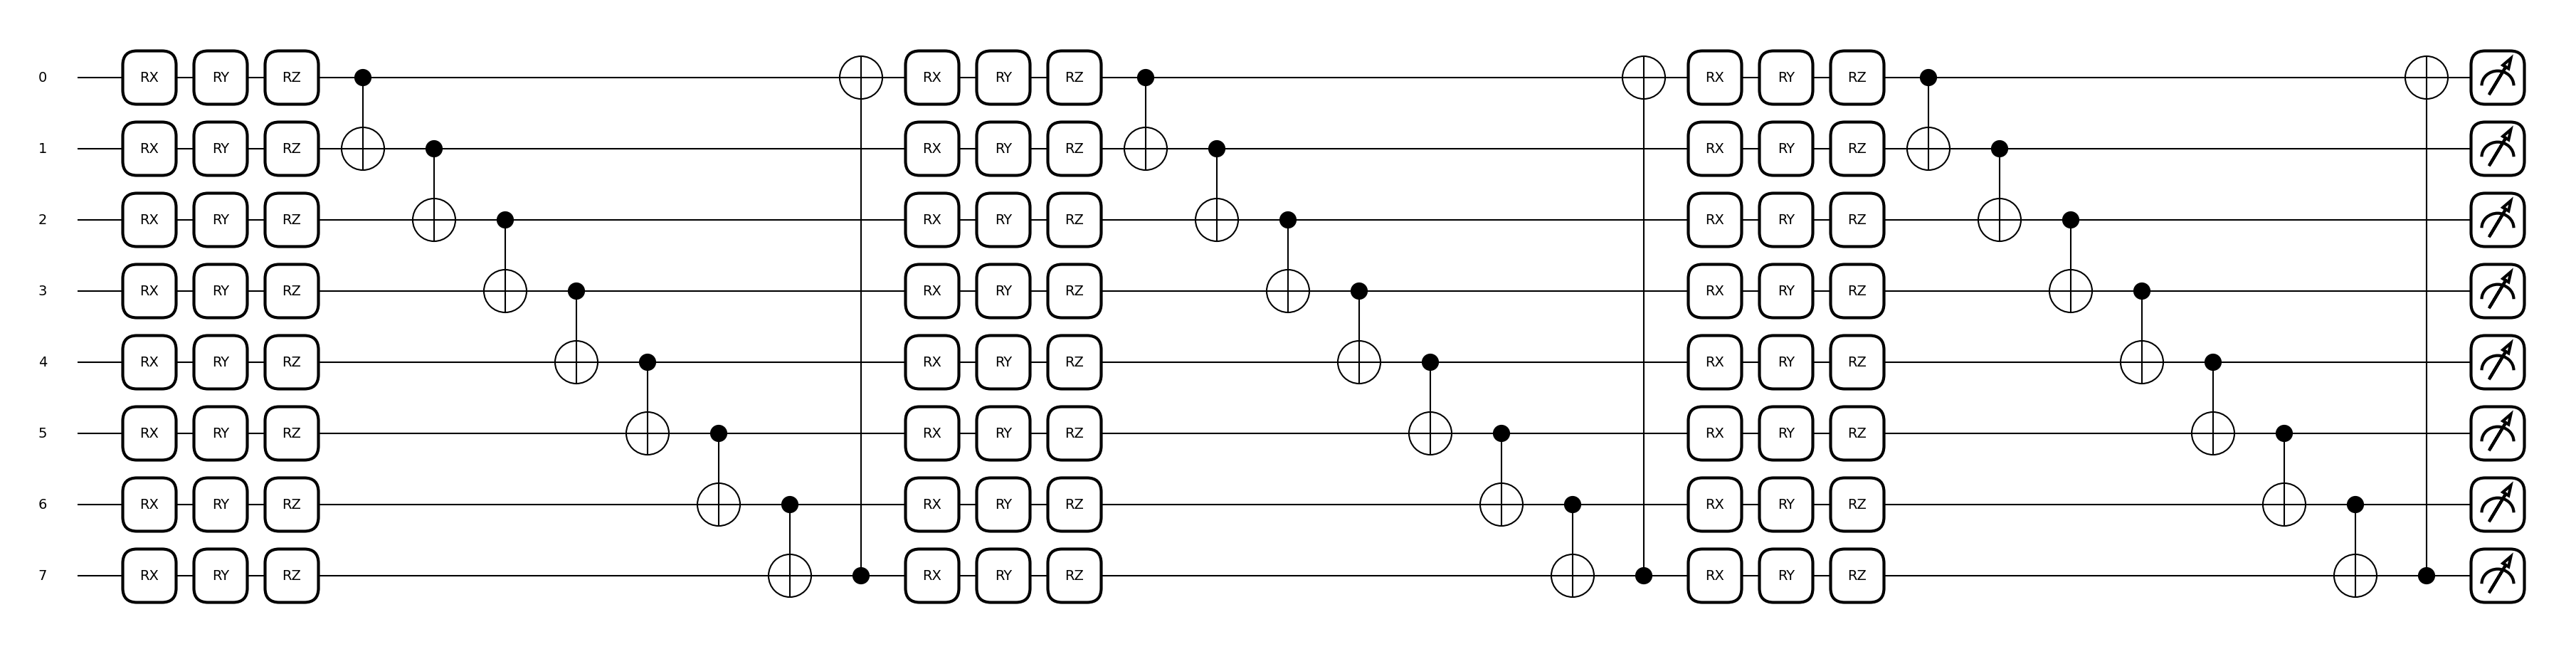

In [45]:
# visualize the qnn
from torch.autograd import Variable

parameters = Variable(torch.normal( mean=0. , std=0.1, size=(NUM_LAYERS, NUM_QUBITS, 3)), requires_grad=True)

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit_block)(parameters)
plt.show()

Definition of a full training

In [46]:
def run_exp(learning_rate, num_layers, batch_size, num_epochs, num_qubits, dataloader, loss_fn):

    loss_history = []

    # initialize parameters randomly
    params = torch.randn((num_layers, num_qubits, 3), requires_grad=True)

    # define the optimizer
    optimizer = torch.optim.Adam([params], lr=learning_rate)

    avg_time_per_epoch = 0

    # training loop for classification
    for epoch in range(num_epochs):

        t0 = time()

        # Initialize tqdm progress bar with description showing the current epoch
        with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as tqdm_epoch:
            for _, (data, labels) in tqdm_epoch:

                # normalize
                data = data / torch.linalg.norm(data, dim=1).view(-1, 1)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                output = circuit(params, data)

                # compute the loss
                loss = loss_fn(output, labels)

                # backward pass
                loss.backward()

                # update the parameters
                optimizer.step()

                # Optionally, update tqdm bar with batch loss
                tqdm_epoch.set_postfix(loss=loss.item(), accuracy=torch.sum((output > 0.5) == labels).item() / batch_size)

        avg_time_per_epoch += time()-t0

        loss_history.append(loss.item())

        # print the time
        print("Time per epoch: ", time()-t0)

        # print the loss
        print("Epoch: ", epoch, "Loss: ", loss.item())

        # print the accuracy
        print("Accuracy: ", torch.sum((output > 0.5) == labels).item()/batch_size)

        print("--------------------------------------------------------------------------")

    return avg_time_per_epoch/NUM_EPOCHS, loss_history

Download MNIST and downsample

In [47]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import os

# Download MNIST and prepare transforms
mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))

# Filter for zeros and ones
data = []
targets = []
for image, label in mnist_train:
    if label in [0, 1]:
        data.append(image.squeeze())
        targets.append(label)

data = torch.stack(data)
targets = torch.tensor(targets)

# Select 1024 zeros and 1024 ones for speed
zeros_indices = (targets == 0)
ones_indices = (targets == 1)

zeros = data[zeros_indices]
ones = data[ones_indices]

# take a subsample of the dataset for simplicity
zeros = zeros[:1024]
ones = ones[:1024]

Normalize images between 0 and 1

In [48]:
zeros_max = torch.max(zeros.reshape(-1, 16*16), dim = 1)
zeros_min = torch.min(zeros.reshape(-1, 16*16), dim = 1)
ones_max = torch.max(ones.reshape(-1, 16*16), dim = 1)
ones_min = torch.min(ones.reshape(-1, 16*16), dim = 1)

def normalize(imgs):
  maxes, _ = torch.max(imgs.reshape(-1, 16*16), dim = 1)
  mins, _ = torch.min(imgs.reshape(-1, 16*16), dim = 1)

  mins = mins.unsqueeze(1).unsqueeze(2)
  maxes = maxes.unsqueeze(1).unsqueeze(2)

  return (imgs-mins)/(maxes-mins)

zeros = normalize(zeros)
ones = normalize(ones)

Print a sample for sanity check

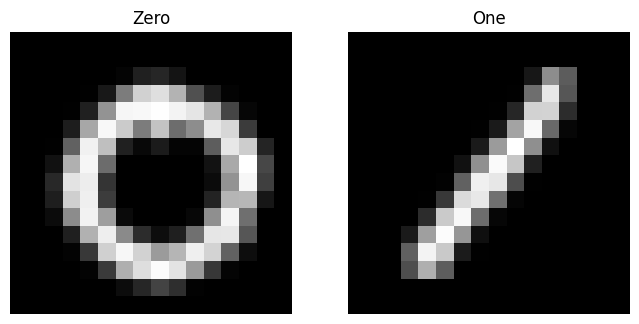

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Select a random sample index
zero_idx = np.random.randint(0, zeros.shape[0])
one_idx = np.random.randint(0, ones.shape[0])

# Extract the images
sample_zero = zeros[zero_idx]
sample_one = ones[one_idx]

# Plot the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(sample_zero, cmap='gray')
ax1.set_title('Zero')
ax1.axis('off')

ax2.imshow(sample_one, cmap='gray')
ax2.set_title('One')
ax2.axis('off')

plt.show()

Define loss and create dataset

In [50]:
# define the cost function
loss_fn = torch.nn.BCELoss()

# assert images have min 0 and max 1 within an error of 1e-5
assert torch.allclose(zeros.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(zeros.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)

# concatenate the two datasets
zeros = zeros.flatten(start_dim = 1)
ones = ones.flatten(start_dim = 1)
dataset = torch.cat((zeros, ones), dim = 0)

# add labels
labels = torch.cat((torch.zeros((zeros.shape[0], 1)), torch.ones((ones.shape[0], 1))), dim = 0).squeeze()

# build dataloader
dataset = torch.utils.data.TensorDataset(dataset, labels)

In [51]:
# take hp combinations
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

print(f'\nRunning experiment with batch size {BATCH_SIZE} and layers {NUM_LAYERS}\n')
dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
time, loss_history = run_exp(LEARNING_RATE, NUM_LAYERS, BATCH_SIZE, NUM_EPOCHS, NUM_QUBITS, dataloader, loss_fn)

# append time and hparams on file
print(f'Average time per epoch: {time} - BS: {BATCH_SIZE} - LAYERS: {NUM_LAYERS}\n')
print('='*50)


Running experiment with batch size 32 and layers 3



Epoch 1/10: 100%|██████████| 64/64 [00:07<00:00,  8.57it/s, accuracy=0.781, loss=0.647]


Time per epoch:  7.477154493331909
Epoch:  0 Loss:  0.6474099159240723
Accuracy:  0.78125
--------------------------------------------------------------------------


Epoch 2/10: 100%|██████████| 64/64 [00:08<00:00,  7.65it/s, accuracy=0.875, loss=0.609]


Time per epoch:  8.378674983978271
Epoch:  1 Loss:  0.6094937324523926
Accuracy:  0.875
--------------------------------------------------------------------------


Epoch 3/10: 100%|██████████| 64/64 [00:08<00:00,  7.53it/s, accuracy=0.938, loss=0.556]


Time per epoch:  8.508057117462158
Epoch:  2 Loss:  0.5563185214996338
Accuracy:  0.9375
--------------------------------------------------------------------------


Epoch 4/10: 100%|██████████| 64/64 [00:07<00:00,  8.74it/s, accuracy=0.938, loss=0.541]


Time per epoch:  7.332484483718872
Epoch:  3 Loss:  0.5407247543334961
Accuracy:  0.9375
--------------------------------------------------------------------------


Epoch 5/10: 100%|██████████| 64/64 [00:08<00:00,  7.82it/s, accuracy=1, loss=0.495]


Time per epoch:  8.200426578521729
Epoch:  4 Loss:  0.49549591541290283
Accuracy:  1.0
--------------------------------------------------------------------------


Epoch 6/10: 100%|██████████| 64/64 [00:07<00:00,  8.78it/s, accuracy=0.969, loss=0.497]


Time per epoch:  7.306655406951904
Epoch:  5 Loss:  0.49709343910217285
Accuracy:  0.96875
--------------------------------------------------------------------------


Epoch 7/10: 100%|██████████| 64/64 [00:07<00:00,  8.04it/s, accuracy=1, loss=0.454]


Time per epoch:  7.96723484992981
Epoch:  6 Loss:  0.4538426399230957
Accuracy:  1.0
--------------------------------------------------------------------------


Epoch 8/10: 100%|██████████| 64/64 [00:09<00:00,  6.97it/s, accuracy=1, loss=0.431]


Time per epoch:  9.191994428634644
Epoch:  7 Loss:  0.43067800998687744
Accuracy:  1.0
--------------------------------------------------------------------------


Epoch 9/10: 100%|██████████| 64/64 [00:07<00:00,  8.37it/s, accuracy=0.969, loss=0.441]


Time per epoch:  7.65749979019165
Epoch:  8 Loss:  0.441336065530777
Accuracy:  0.96875
--------------------------------------------------------------------------


Epoch 10/10: 100%|██████████| 64/64 [00:08<00:00,  7.96it/s, accuracy=1, loss=0.403]

Time per epoch:  8.055199146270752
Epoch:  9 Loss:  0.40280064940452576
Accuracy:  1.0
--------------------------------------------------------------------------
Average time per epoch: 8.00751085281372 - BS: 32 - LAYERS: 3



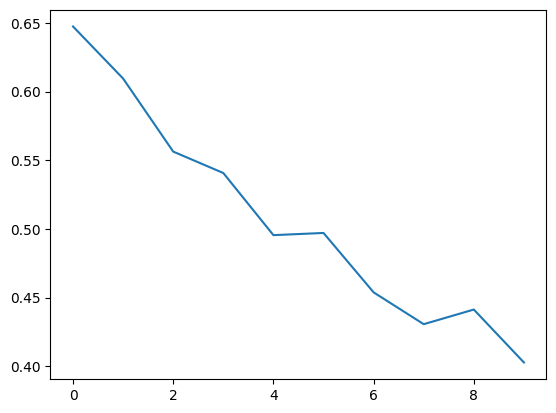

In [52]:
plt.plot(loss_history)
plt.show()